In [1]:
!ls ../data

le01.m4a le04.m4a le07.m4a le10.m4a st03.m4a st06.m4a st09.m4a
le02.m4a le05.m4a le08.m4a st01.m4a st04.m4a st07.m4a st10.m4a
le03.m4a le06.m4a le09.m4a st02.m4a st05.m4a st08.m4a


In [4]:
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np

In [25]:
st01 = AudioSegment.from_file('../data/st01.m4a', 'm4a')

In [26]:
st01_sample = np.array(st01.get_array_of_samples())

In [27]:
st01_sample.shape

(363744,)

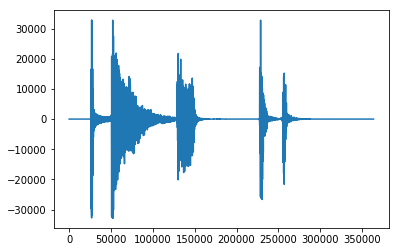

In [28]:
plt.plot(st01_sample)

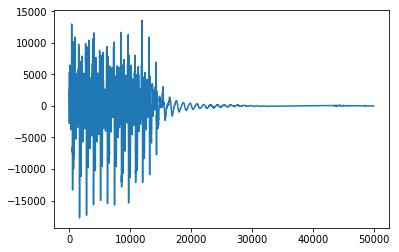

In [29]:
r_idx = np.random.choice(st01_sample.shape[0] - 50000)
st01_frag = st01_sample[r_idx: r_idx + 50000]
plt.plot(st01_frag)

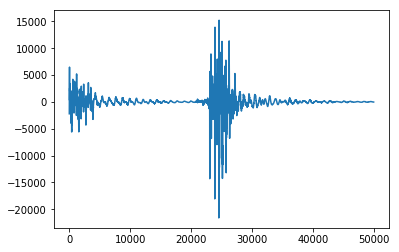

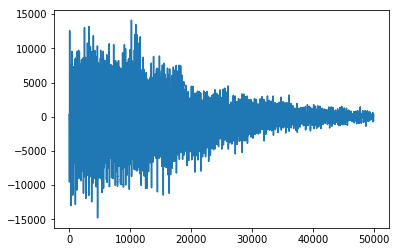

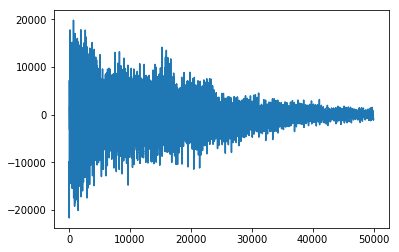

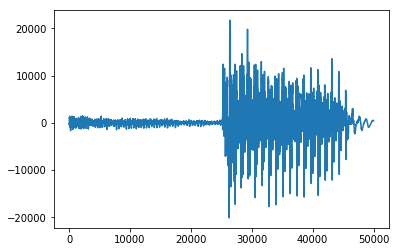

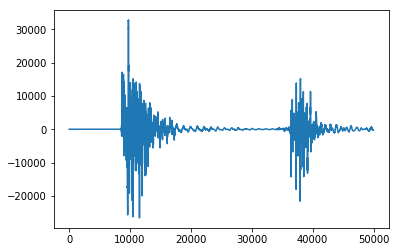

In [30]:
for _ in range(5):
    r_idx = np.random.choice(st01_sample.shape[0] - 50000)
    st01_frag = st01_sample[r_idx: r_idx + 50000]
    plt.plot(st01_frag)
    plt.show()

In [17]:
# Data loader, processor, augmentation
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
from pydub import AudioSegment
import numpy as np

sounds = []
g_class = [] # Stratocaster: 0, Les Paul: 1
f_names = []
datas = []
specs = []
waves = []
d_names = []

for f_name in pathlib.Path('../data').iterdir():
    
    sounds.append(AudioSegment.from_file('../data/' + f_name.name, 'm4a'))
    datas.append(np.array(AudioSegment.from_file('../data/' + f_name.name, 'm4a').get_array_of_samples()))
    
    # Augmentation
    
    for i in range(100):
        g_class.append(int('le' in f_name.name))
        #f_names.append(('_' + str(i) + '.').join(f_name.name.split('.')))
        d_names.append(('_' + str(i) + '.').join(f_name.name.split('.')))
        
        r_idx = np.random.choice(datas[-1].shape[0] - 50000)

        data = datas[-1][r_idx: r_idx + 50000]
        waves.append(data)
        sampling_rate = 48000
        NFFT = 1024 
        OVERLAP = NFFT / 2 
        frame_length = data.shape[0] 
        split_number = len(np.arange((NFFT / 2), frame_length, (NFFT - OVERLAP))) 

        window = np.hamming(NFFT)  

        spec = np.zeros([split_number, NFFT // 4]) 


        pos = 0

        for fft_index in range(split_number):
            frame = data[int(pos):int(pos+NFFT)]
            if len(frame) == NFFT:
                windowed = window * frame  
                fft_result = np.fft.rfft(windowed)

                fft_data2 = np.real(fft_result[:int(len(fft_result)/2)]) 
                fft_data2 = np.log(fft_data2** 2)  

                for i in range(len(spec[fft_index])):
                    spec[fft_index][-i-1] = fft_data2[i]

                pos += (NFFT - OVERLAP)

        specs.append(spec.T)

g_class = np.eye(2)[g_class]
print('fine')

fine


In [19]:
len(waves)

2000

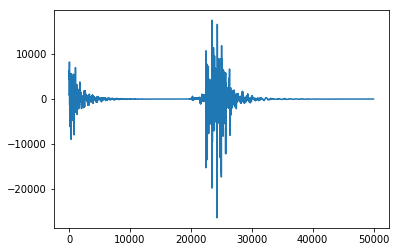

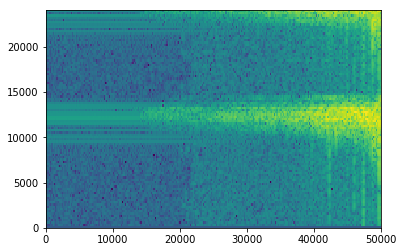

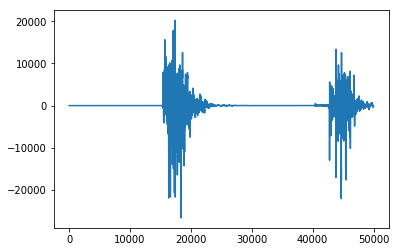

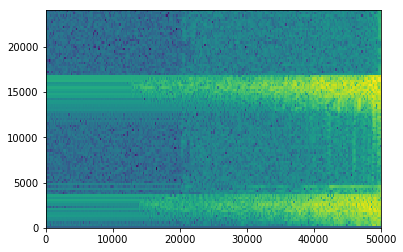

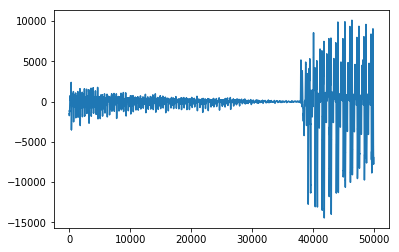

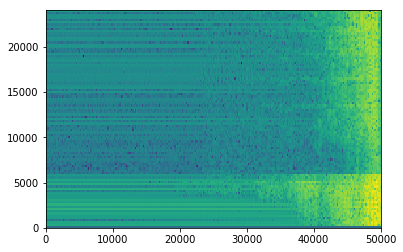

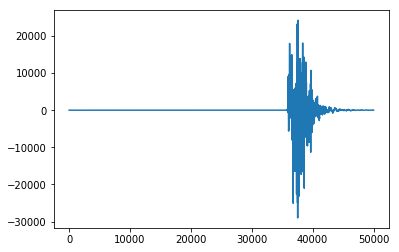

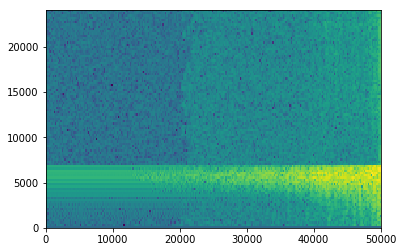

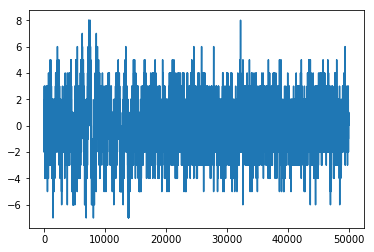

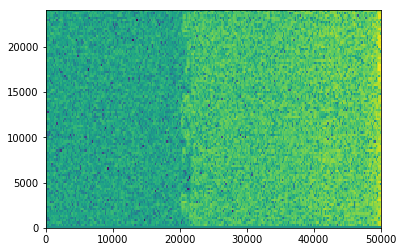

In [32]:
for _ in range(5):
    i = np.random.choice(2000)
    plt.plot(waves[i])
    plt.show()
    plt.imshow(specs[i].T, extent=[0, frame_length, 0, sampling_rate/2], aspect="auto")
    plt.show()

In [35]:
#g_class = np.eye(2)[g_class]
#g_class

In [36]:
# Network
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def tf_log(x):
    return tf.log(tf.clip_by_value(x, 1e-10, x))

tf.reset_default_graph()

is_training = tf.placeholder(tf.bool, shape=())

x = tf.placeholder(shape=[None, 256, 97, 1], dtype=tf.float32)
t = tf.placeholder(tf.float32, [None, 2])

h = tf.keras.layers.Conv2D(filters=32, kernel_size= [3, 3])(x) 
h = tf.keras.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) 

h = tf.keras.layers.Conv2D(filters=64, kernel_size= [3, 3])(h) 
h = tf.keras.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) 

h = tf.keras.layers.Conv2D(filters=128, kernel_size= [3, 3])(h) 
h = tf.keras.layers.BatchNormalization()(h, training=is_training)
h = tf.nn.relu(h)
h = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(h) 

h = tf.keras.layers.Flatten()(h)
h = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)(h)
y = tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)(h)

cost = - tf.reduce_mean(tf.reduce_sum(t * tf_log(y), axis = 1))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [37]:
x_train, x_test, t_train, t_test = train_test_split(specs, g_class, test_size = 0.2)

x_train = np.array(x_train) / np.array(x_train).max()
x_test = np.array(x_test) / np.array(x_test).max()
t_train = np.array(t_train)
t_test = np.array(t_test)

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(1600, 256, 97)
(1600, 2)
(400, 256, 97)
(400, 2)


In [65]:
x_train = np.array(specs) / np.array(specs).max()
t_train = np.array(g_class)

n_epochs = 10
batch_size = 128
n_batches = x_train.shape[0] // batch_size
errflag = False

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for epoch in range(n_epochs):
    x_train, t_train = shuffle(x_train, t_train)
    for batch in range(n_batches):
        start = batch * batch_size
        end = start + batch_size
        sess.run(optimizer, feed_dict={x: x_train[start:end][:, :, :, None], t: t_train[start:end], is_training: True})
    
    if epoch % 1 == 0:
        y_pred, cost_test = sess.run([y, cost], feed_dict={x: x_test[:, :, :, None], t: t_test, is_training: False})
        print('EPOCH: {}, Test Cost: {:.3f}, Test Accuracy: {:.3f}'.format(
            epoch,
            cost_test,
            accuracy_score(t_test.argmax(axis=1), y_pred.argmax(axis=1))
        ))
        print(np.sum(t_test.argmax(axis = 1) == 1), np.sum(y_pred.argmax(axis = 1) == 1))
    
    if epoch == 0 and (np.sum(np.sum(y_pred.argmax(axis = 1) == 1) == 0 or np.sum(y_pred.argmax(axis = 1) == 1) == 400)):
        errflag = True
        break

if(not errflag):
    saver = tf.train.Saver()
    saver.save(sess, '../model/model')
        
sess.close()
print('fine')

EPOCH: 0, Test Cost: 11.666, Test Accuracy: 0.485
206 0
fine


In [42]:
x_train.shape[0] // batch_size

15

In [43]:
batch

13

In [57]:
np.sum(y_pred.argmax(axis = 1) == 0)

400

In [62]:
sess.close()

In [ ]:
x_train = np.array(specs) / np.array(specs).max()
t_train = np.array(g_class)


for _ in range(10):
    n_epochs = 10
    batch_size = 128
    n_batches = x_train.shape[0] // batch_size
    errflag = False

    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(n_epochs):
        x_train, t_train = shuffle(x_train, t_train)
        for batch in range(n_batches):
            start = batch * batch_size
            end = start + batch_size
            sess.run(optimizer, feed_dict={x: x_train[start:end][:, :, :, None], t: t_train[start:end], is_training: True})

        if epoch % 1 == 0:
            y_pred, cost_test = sess.run([y, cost], feed_dict={x: x_test[:, :, :, None], t: t_test, is_training: False})
            print('EPOCH: {}, Test Cost: {:.3f}, Test Accuracy: {:.3f}'.format(
                epoch,
                cost_test,
                accuracy_score(t_test.argmax(axis=1), y_pred.argmax(axis=1))
            ))
            print(np.sum(t_test.argmax(axis = 1) == 1), np.sum(y_pred.argmax(axis = 1) == 1))

        if epoch == 0 and (np.sum(np.sum(y_pred.argmax(axis = 1) == 1) == 0 or np.sum(y_pred.argmax(axis = 1) == 1) == 400)):
            errflag = True
            break

    if(not errflag):
        saver = tf.train.Saver()
        saver.save(sess, '../model/model')

    sess.close()
    print('fine')